In [1]:
!pip install selenium
!pip install BeautifulSoup4

In [2]:
import pandas as pd
import numpy as np

## 1. Read the CSV of companies and tickers prepared previously.
Create a dataframe to store the following:
- Ticker
- Company Name

In [6]:
companies = pd.read_csv("top50companies.csv")
companies.head()

,Ticker,Company
0,AAPL,Apple Inc.
1,MSFT,Microsoft Corporation
2,AMZN,"Amazon.com, Inc."
3,NVDA,NVIDIA Corporation
4,GOOGL,Alphabet Inc.


### 2. Iterate through each row to scrape the company's ESG scores from S&P Global ESG website using Selenium and BeautifulSoup
S&P Global ESG Website (https://www.spglobal.com/esg/solutions/data-intelligence-esg-scores)
- For each company, we will be scraping `Criteria Topic` scores
  - Criteria Topic: String
  - Score: integer (company score, industry best, industry mean)
- We will also be scraping the `industry` that the company is categorized under

In [8]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time

chrome_options = Options()
chrome_options.add_argument('--headless')
driver = webdriver.Chrome("/chromedriver", options=chrome_options)

driver.get("https://www.spglobal.com/esg/scores/")
time.sleep(3)
click_accept = driver.find_elements(By.XPATH, '//*[@id="onetrust-accept-btn-handler"]')
click_accept[0].click()

criteria_scores = {}
company_industry = {}

for index, row in companies.iterrows():
    ticker = row['Ticker']
    name = row['Company']
    print(f"Scraping #{index+1} {name}...")
    if index == 0:
        search_box = driver.find_elements(By.XPATH, "/html/body/div[3]/div[11]/div/div[3]/div/div/div[2]/div[1]/input")
        search_box[0].send_keys(name)
    else:
        search_box = driver.find_elements(By.XPATH, "/html/body/div[3]/div[1]/div[3]/div/div/div[2]/div[1]/input")
        search_box[0].send_keys(name)
    time.sleep(1)
    search_box[0].send_keys(Keys.ENTER)
    time.sleep(5)

    try:
        ESG_score = driver.find_elements(By.XPATH, '//*[@id="esg-score"]')[0].text
        industry = driver.find_elements(By.XPATH, '//*[@id="company-industry"]')[0].text
        company_industry[ticker] = industry
        time.sleep(3)

        criteria_scores[ticker] = {}
        criteria_scores[ticker]['Company Performance'] = []
        criteria_scores[ticker]['Industry Best Performance'] = []
        criteria_scores[ticker]['Industry Mean Performance'] = []

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        company_perf = soup.find('g', {'class' : 'highcharts-markers highcharts-series-0 highcharts-area-series highcharts-tracker'})
        company_points = company_perf.find_all('path', {'class': 'highcharts-point'})
        for point in company_points:
            label = point.get('aria-label')
            criteria_scores[ticker]['Company Performance'].append(label)

        industry_mean = soup.find('g', {'class' : 'highcharts-markers highcharts-series-2 highcharts-line-series highcharts-tracker'})
        industry_mean_points = industry_mean.find_all('path', {'class': 'highcharts-point'})
        for point in industry_mean_points:
            label = point.get('aria-label')
            criteria_scores[ticker]['Industry Mean Performance'].append(label)

        industry_best = soup.find('g', {'class' : 'highcharts-markers highcharts-series-1 highcharts-line-series highcharts-tracker'})
        industry_best_points = industry_best.find_all('path', {'class': 'highcharts-point'})
        for point in industry_best_points:
            label = point.get('aria-label')
            criteria_scores[ticker]['Industry Best Performance'].append(label)

        industry = driver.find_elements(By.XPATH, '//*[@id="company-industry"]')[0].text
        company_industry[ticker] = industry

    except:
        if index == 0:
            search_box = driver.find_elements(By.XPATH, "/html/body/div[3]/div[11]/div/div[3]/div/div/div[2]/div[1]/input")
            search_box[0].clear()
        else:
            search_box = driver.find_elements(By.XPATH, "/html/body/div[3]/div[1]/div[3]/div/div/div[2]/div[1]/input")
            search_box[0].clear()
        print(f"unable to scrape {ticker}")
    print(f"Scraping #{index+1} {name} Done")
print("Scraping Completed")
driver.close()

/var/folders/27/xh3tm0h964n5gjzv1brx5vrc0000gn/T/ipykernel_78650/710882320.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("/chromedriver", options=chrome_options)


Scraping #1 Apple Inc....
Scraping #1 Apple Inc. Done
Scraping #2 Microsoft Corporation...
Scraping #2 Microsoft Corporation Done
Scraping #3 Amazon.com, Inc....
Scraping #3 Amazon.com, Inc. Done
Scraping #4 NVIDIA Corporation...
Scraping #4 NVIDIA Corporation Done
Scraping #5 Alphabet Inc....
Scraping #5 Alphabet Inc. Done
Scraping #6 Tesla, Inc....
Scraping #6 Tesla, Inc. Done
Scraping #7 Meta Platforms, Inc....
Scraping #7 Meta Platforms, Inc. Done
Scraping #8 UnitedHealth Group Incorporated...
Scraping #8 UnitedHealth Group Incorporated Done
Scraping #9 Exxon Mobil Corporation...
Scraping #9 Exxon Mobil Corporation Done
Scraping #10 JPMorgan Chase & Co....
Scraping #10 JPMorgan Chase & Co. Done
Scraping #11 Visa Inc....
Scraping #11 Visa Inc. Done
Scraping #12 The Procter & Gamble Company...
Scraping #12 The Procter & Gamble Company Done
Scraping #13 Mastercard Incorporated...
Scraping #13 Mastercard Incorporated Done
Scraping #14 Chevron Corporation...
Scraping #14 Chevron Corpora

### 3. Process the scrapped data

In [9]:
# Helper Function to Process Scrapped Data
def process_scraped_data(scores):
    """
    Takes in scrapped data and extract Historical ESG Scores, Company Performance in various categories,
    and Industry Performances (Mean and Best) in the same categories.

    Returns historical_ESG_scores -> dict, ESG_component_scores -> dict, company_performances -> dict
    """
    company_performances = {}

    for ticker, scrapped_data in scores.items():
        company_performances[ticker] = {}

        for data in scrapped_data['Company Performance']:
            if "/ " in data: # to handle "Information Security/ Cybersecurity & System Availability"
                data = data.replace("/ ", " ")
            split = data.split(", ")
            category = split[0].split(". ")[-1]
            perf_score = split[-1].split(".")[0]
            if category not in company_performances[ticker].keys():
                company_performances[ticker][category] = {}    
            company_performances[ticker][category]['Company'] = int(perf_score)

        for data in scrapped_data['Industry Best Performance']:
            if "/ " in data: # to handle "Information Security/ Cybersecurity & System Availability"
                data = data.replace("/ ", " ")
            split = data.split(", ")
            category = split[0].split(". ")[-1]
            perf_score = split[-1].split(".")[0]
            if category not in company_performances[ticker].keys():
                company_performances[ticker][category] = {}  
            company_performances[ticker][category]['Industry Best'] = int(perf_score)

        for data in scrapped_data['Industry Mean Performance']:
            if "/ " in data: # to handle "Information Security/ Cybersecurity & System Availability"
                data = data.replace("/ ", " ")
            split = data.split(", ")
            category = split[0].split(". ")[-1]
            perf_score = split[-1].split(".")[0]
            if category not in company_performances[ticker].keys():
                company_performances[ticker][category] = {}  
            company_performances[ticker][category]['Industry Mean'] = int(perf_score)

    return company_performances

In [10]:
company_performances = process_scraped_data(historical_scores)

### 4. Store them as a dictionary of dataframes:
- Key: Company ticker
- Value: Dataframe (Company, Industry Best, Industry Mean Scores of Criteria Topics)

In [17]:
performance_dict = {}
for ticker, data in company_performances.items():
    performance_dict[ticker] = pd.DataFrame.from_dict(data, orient='index').sort_index()
    performance_dict[ticker] = performance_dict[ticker].rename(columns={'Company': ticker})
performance_dict['AAPL']

,AAPL,Industry Best,Industry Mean
Climate Strategy,78,98,32
Human Capital Development,45,100,42
Human Rights,33,100,27
Information Security Cybersecurity & System Availability,16,93,25
Innovation Management,4,100,18
Operational Eco-Efficiency,74,100,36
Product Stewardship,59,100,24
Supply Chain Management,6,99,26


In [54]:
performance_dict['NEE']

,NEE,Industry Best,Industry Mean
Business Ethics,42,100,43
Climate Strategy,65,99,30
Electricity Generation,34,100,40
Market Opportunities,32,100,21
Occupational Health & Safety,23,99,34
Operational Eco-Efficiency,45,99,35
Risk & Crisis Management,38,100,28
Stakeholder Engagement,12,100,24
Talent Attraction & Retention,4,100,22


### Export each dataframe into 1 csv file

In [38]:
criteria_topics_lst = []
for company, df in performance_dict.items():
    for topic in list(df.index):
        if topic not in criteria_topics_lst:
            criteria_topics_lst.append(topic)
    df.to_csv(f"scraped_data/{company}_criteria_topic_scores.csv")

In [41]:
with open("criteria_topics.txt", "w") as f:
    f.write(str(criteria_topics_lst))    

### 5. Exploratory Data Analysis 

In [21]:
# Scrape Criteria Topics Mappings from S&P Global Website
chrome_options = Options()
chrome_options.add_argument('--headless')
driver = webdriver.Chrome("/chromedriver", options=chrome_options)

driver.get("https://www.spglobal.com/esg/scores/")
time.sleep(3)
criteria_list_container = driver.find_elements(By.XPATH, '/html/body/div[3]/div[17]/div')[0]
headers = criteria_list_container.find_elements(By.CLASS_NAME, 'item__header-title')
topics = criteria_list_container.find_elements(By.CLASS_NAME, 'item__content__list')

criteria_topic_mappings = {}
for social_topic in topics[0].text.split("\n"):
    criteria_topic_mappings[social_topic] = headers[0].text.split("\n")[0]

for environmental_topic in topics[1].text.split("\n"):
    criteria_topic_mappings[environmental_topic] = headers[1].text.split("\n")[0] + "s"
    
for governance_topic in topics[2].text.split("\n"):
    criteria_topic_mappings[governance_topic] = headers[2].text.split("\n")[0] + " Dimensions"

/var/folders/27/xh3tm0h964n5gjzv1brx5vrc0000gn/T/ipykernel_78650/1863327667.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("/chromedriver", options=chrome_options)


In [34]:
df_dict = {}

for topic, dimension in criteria_topic_mappings.items():
    if dimension not in df_dict:
        df_dict[dimension] = []
    df_dict[dimension].append(topic)

criteria_topic_df = pd.DataFrame.from_dict(df_dict, orient='index').transpose()
criteria_topic_df.to_csv("Criteria Topics.csv", index=False)

In [45]:
grouped_companies = {}

for ticker, industry in company_industry.items():
    if industry not in grouped_companies:
        grouped_companies[industry] = []
    grouped_companies[industry].append(ticker)

In [53]:
companies_industry = {}
for industry, companies in grouped_companies.items():
    for company in companies:
        companies_industry[company] = industry
with open("company_industry_mapping.txt", "w") as f:
    f.write(str(companies_industry))

In [57]:
industry_criteria_df['Industry: ELC Electric Utilities']

KeyError: 'Industry: ELC Electric Utilities'

#### Findings:
- We found that each industry has its own subset of criteria topic that may differ from other industries. These criteria topics represent the ESG topics that are most relevant to the industry

In [58]:
# for industries with more than 1 company, we will see the criteria topics
industry_criteria_topic = {}
criteria_topic_counts = {}
for industry, companies in grouped_companies.items():
    industry_criteria_topic[industry] = []
    criteria_topic_counts[industry] = {}
    for company in companies:
        for topic in list(performance_dict[company].index):
            if topic not in industry_criteria_topic[industry]:
                industry_criteria_topic[industry].append(topic)
            if topic not in criteria_topic_counts[industry]:
                criteria_topic_counts[industry][topic] = 1
            else:
                criteria_topic_counts[industry][topic] +=1 

industry_criteria_df = pd.DataFrame.from_dict(industry_criteria_topic, orient='index').transpose()

# save as CSV
industry_criteria_df.to_csv("Industry Criteria Topics.csv", index=False)

industry_criteria_df

,Industry: THQ Computers & Peripherals and Office Electronics,Industry: SOF Software,Industry: RTS Retailing,Industry: SEM Semiconductors & Semiconductor Equipment,"Industry: IMS Interactive Media, Services & Home Entertainment",Industry: AUT Automobiles,Industry: HEA Health Care Providers & Services,Industry: OGX Oil & Gas Upstream & Integrated,Industry: BNK Banks,Industry: TSV IT services,...,Industry: REX Restaurants & Leisure Facilities,Industry: MTC Health Care Equipment & Supplies,"Industry: PUB Media, Movies & Entertainment",Industry: CHM Chemicals,Industry: TLS Telecommunication Services,Industry: ELC Electric Utilities,Industry: TOB Tobacco,"Industry: TEX Textiles, Apparel & Luxury Goods",Industry: ARO Aerospace & Defense,Industry: TRA Transportation and Transportation Infrastructure
0,Climate Strategy,Climate Strategy,Climate Strategy,Climate Strategy,Climate Strategy,Climate Strategy,Access to Healthcare,Biodiversity,Business Ethics,Climate Strategy,...,Biodiversity,Business Ethics,Climate Strategy,Business Ethics,Biodiversity,Business Ethics,Business Ethics,Circular Fashion,Business Ethics,Business Ethics
1,Human Capital Development,Environmental Policy & Management Systems,Human Rights,Environmental Policy & Management Systems,Human Capital Development,Corporate Governance,Business Ethics,Business Ethics,Climate Strategy,Environmental Policy & Management Systems,...,Business Ethics,Health Outcome Contribution,Human Capital Development,Climate Strategy,Climate Strategy,Climate Strategy,Climate Strategy,Climate Strategy,Climate Strategy,Climate Strategy
2,Human Rights,Human Capital Development,Labor Practice Indicators,Human Capital Development,Information Security Cybersecurity & System Av...,Human Capital Development,Human Capital Development,Climate Strategy,Corporate Governance,Human Capital Development,...,Climate Strategy,Human Capital Development,Information Security Cybersecurity & System Av...,Human Capital Development,Human Capital Development,Electricity Generation,Human Capital Development,Human Rights,Compliance with Applicable Export Control Regimes,Fuel Efficiency
3,Information Security Cybersecurity & System Av...,Information Security Cybersecurity & System Av...,Operational Eco-Efficiency,Innovation Management,Innovation Management,Innovation Management,Labor Practice Indicators,Energy Mix,Decarbonization Strategy,Information Security Cybersecurity & System Av...,...,Human Rights,Innovation Management,Labor Practice Indicators,Innovation Management,Information Security Cybersecurity & System Av...,Market Opportunities,Human Rights,Labor Practice Indicators,Human Capital Development,Occupational Health & Safety
4,Innovation Management,Innovation Management,Packaging,Operational Eco-Efficiency,Operational Eco-Efficiency,Low Carbon Strategy,Occupational Health & Safety,Human Rights,Financial Inclusion,Innovation Management,...,Labor Practice Indicators,Operational Eco-Efficiency,Operational Eco-Efficiency,Occupational Health & Safety,Network Reliability,Occupational Health & Safety,Innovation Management,Occupational Health & Safety,Human Rights,Operational Eco-Efficiency
5,Operational Eco-Efficiency,Operational Eco-Efficiency,Risk & Crisis Management,Product Quality & Recall Management,Responsibility of Content,Occupational Health & Safety,Operational Eco-Efficiency,Occupational Health & Safety,Human Capital Development,Operational Eco-Efficiency,...,Occupational Health & Safety,Product Quality & Recall Management,Responsibility of Content,Operational Eco-Efficiency,Operational Eco-Efficiency,Operational Eco-Efficiency,Occupational Health & Safety,Product Stewardship,Occupational Health & Safety,Risk & Crisis Management
6,Product Stewardship,Talent Attraction & Retention,Supply Chain Management,Product Stewardship,Talent Attraction & Retention,Operational Eco-Efficiency,Risk & Crisis Management,Operational Eco-Efficiency,Risk & Crisis Management,Talent Attraction & Retention,...,Operational Eco-Efficie

#### Findings: We also found that all the companies under the same industry share the same subset of criteria topic as well.
- Example: 
  - "Industry: SOF Software" has 2 companies in our list,
  - Each criteria topic appeared 2 times, thus showing that it appeared for both companies

In [129]:
for industry, topics in criteria_topic_counts.items():
    numCompanies = len(grouped_companies[industry])
    print(f"{industry}")
    print(f"Number of Companies: {numCompanies}")
    print(f"Count of Topics:")
    for topic, count in topics.items():
        print(f"    {topic}: {count}")
    print("###########################\n")

Industry: SOF Software
Number of Companies: 2
Count of Topics:
    Climate Strategy: 2
    Environmental Policy & Management Systems: 2
    Human Capital Development: 2
    Information Security Cybersecurity & System Availability: 2
    Innovation Management: 2
    Operational Eco-Efficiency: 2
    Talent Attraction & Retention: 2
###########################

Industry: RTS Retailing
Number of Companies: 2
Count of Topics:
    Climate Strategy: 2
    Human Rights: 2
    Labor Practice Indicators: 2
    Operational Eco-Efficiency: 2
    Packaging: 2
    Risk & Crisis Management: 2
    Supply Chain Management: 2
    Sustainable Marketing & Brand Perception: 2
###########################

Industry: SEM Semiconductors & Semiconductor Equipment
Number of Companies: 6
Count of Topics:
    Climate Strategy: 6
    Environmental Policy & Management Systems: 6
    Human Capital Development: 6
    Innovation Management: 6
    Operational Eco-Efficiency: 6
    Product Quality & Recall Management: 6

#### Plot the S&P 500 companies' performance against industry mean and best
- Since we have 27 companies, it would be impossible to plot every single industry.
- As such, we have decided to only plot the top 3 industries with the most companies in our list.

In [192]:
top_3_industries = sorted(grouped_companies.items(), key= lambda x: len(x[1]), reverse=True)[:3]
top_3_industries

[('Industry: SEM Semiconductors & Semiconductor Equipment',
  ['NVDA', 'AVGO', 'TXN', 'AMD', 'QCOM', 'INTC']),
 ('Industry: DRG Pharmaceuticals', ['LLY', 'MRK', 'PFE', 'BMY']),
 ('Industry: BNK Banks', ['JPM', 'BAC', 'WFC'])]

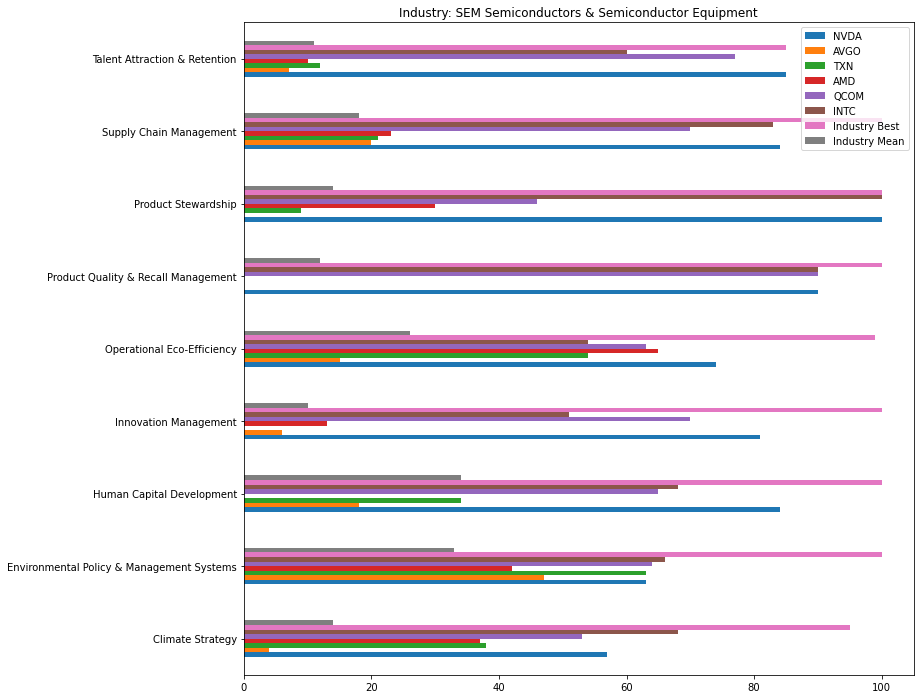

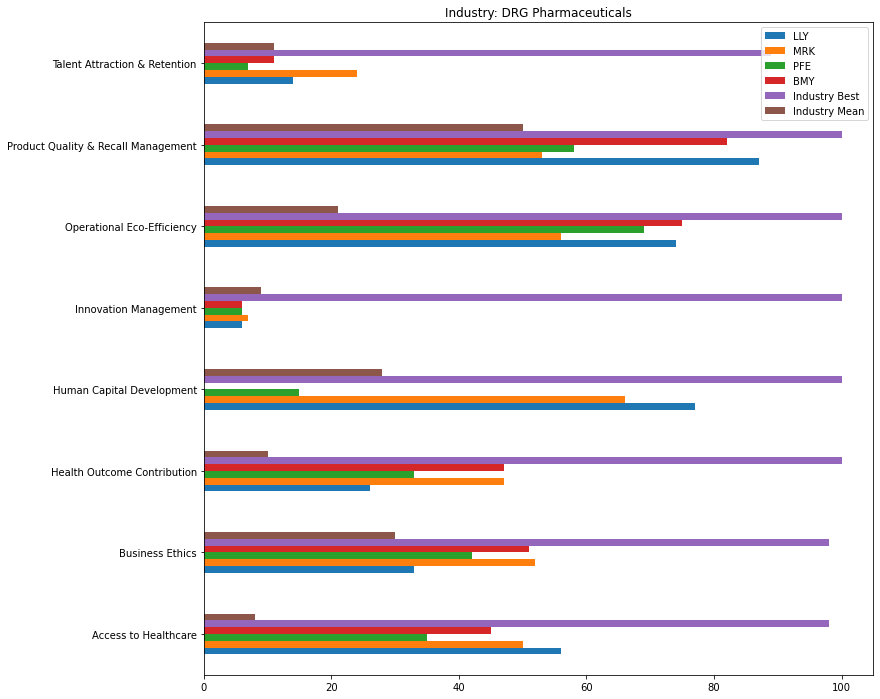

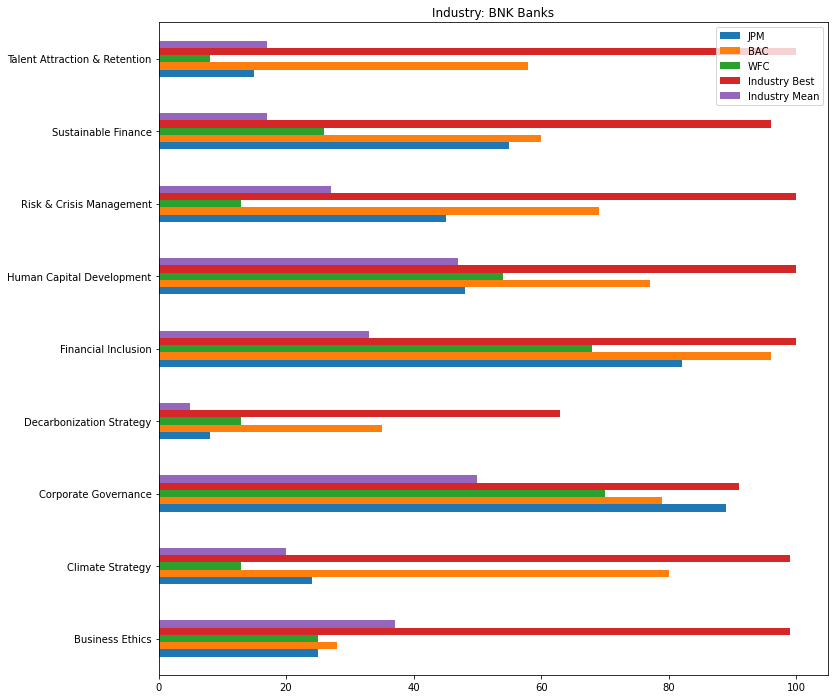

In [197]:
import matplotlib.pyplot as plt

for i in top_3_industries:
    industry = i[0]
    companies = i[1]
    combined_df = pd.concat(industry_performances[industry], axis=1, join='inner')
    combined_df = combined_df.loc[:, ~combined_df.columns.duplicated(keep='first')]
    ordering = companies + ['Industry Best', 'Industry Mean']
    combined_df = combined_df.reindex(columns=ordering)
    combined_df.plot(kind='barh', figsize=(12,12), title=industry)